# Implementation of YOLOv3 with OpenCV

This notebook is a companion of the book "Advanced deep learning" by Umberto Michelucci (umberto.michelucci(at)toelt.ai)

https://www.apress.com/gp/book/9781484249758

You can find the original documentation of the functions on the opencv website.

https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/

In [86]:
import numpy as np
import argparse
import time
import cv2
import os

import matplotlib.pyplot as plt

The version used for this notebooks is

In [87]:
print (cv2. __version__)

4.1.0


In particular we will use extensively the ```cv2.dnn``` package and functions that enables to implement yolo in a very easy and simple manner in any application written in Python where you work with images. In addition, since is cv2, if you are already using it, you can simply extend the functionalities of your code with object detection.

First we need to load the names of the classes on which the network has been trained on. Keep in mind that the network we use will only be able to recognize the classes that has been trained on.

In [3]:
labelsPath = "yolo-coco/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

In [4]:
LABELS[1:5]

['bicycle', 'car', 'motorbike', 'aeroplane']

Now for each class, we will generate a random color. We will use this color later on when drawing the bounding boxes around the objects.

In [5]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [6]:
COLORS[0:5]

array([[102, 220, 225],
       [ 95, 179,  61],
       [234, 203,  92],
       [  3,  98, 243],
       [ 14, 149, 245]], dtype=uint8)

We need now to load the ```cfg``` file (where the structure of the network is described), and the pre-trained weights.

In [7]:
weightsPath = "yolo-coco/yolov3.weights"
configPath = "yolo-coco/yolov3.cfg"

In [8]:
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


Now we load the image we want to analyse. Feel free to change with yours here.

In [115]:
image = cv2.imread("images/table.jpg")
imageorig = cv2.imread("images/table.jpg")
(H, W) = image.shape[:2]

In [104]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [105]:
ln

['yolo_82', 'yolo_94', 'yolo_106']

We need to resize the image to a square one 416x416 pixels and do a forward pass through the network.

In [106]:
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

In [107]:
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 0.223133 seconds


In [114]:
boxes = []
confidences = []
classIDs = []

Now let's select the bounding boxes found. 

In [109]:
# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        if confidence > 0.15:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

In [110]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.6,0.2)

In [111]:
# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # draw a bounding box rectangle and label on the image
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 20)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            3, color, 12)


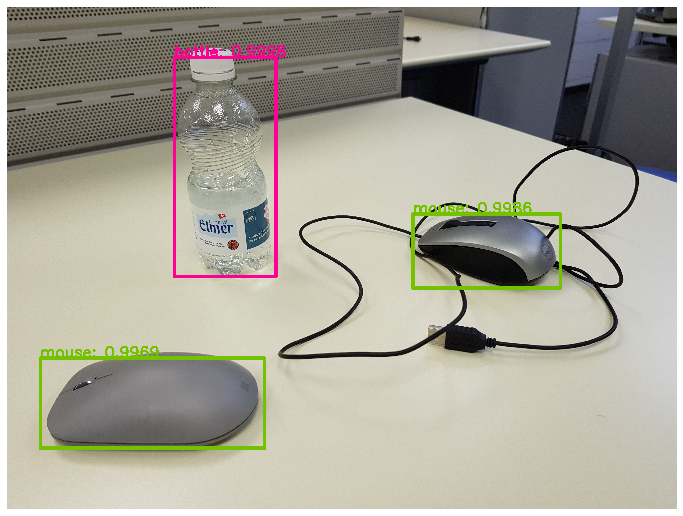

In [112]:
fig = plt.figure(figsize = (12,10))
plt.imshow(image[:,:,::-1])
plt.axis('off')
plt.savefig('table_yolo.jpg', dpi = 300)

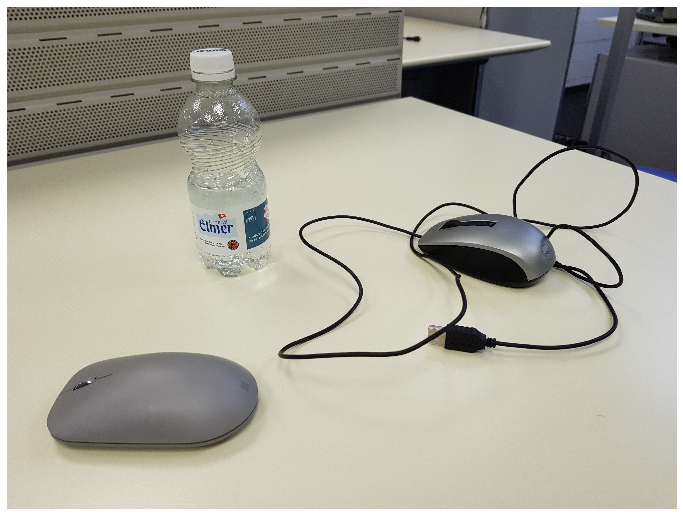

In [113]:
plt.figure(figsize = (12,10))
plt.imshow(imageorig[:,:,::-1])

plt.axis('off')
plt.savefig('table_orig.jpg', dpi = 300)